# Overview on reflax

## Imports

In [1]:
# ==== GPU selection ====
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
# =======================

# NOTE: without 64-bit precision,
# the Cholesky decomposition used
# in sampling thickness profiles
# will fail, apart from that single
# precision is sufficient
from jax import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

# simulator setup
from reflax._reflectance_models._one_layer_model import get_polarization_components
from reflax.parameter_classes.parameters import (
    ForwardModelParams,
    LayerParams,
    SetupParams,
    LightSourceParams,
    TransmissionMediumParams,
    IncidentMediumParams
)

# constants
from reflax import (
    ONE_LAYER_MODEL,
    TRANSFER_MATRIX_METHOD,
    S_POLARIZED,
    NO_NORMALIZATION,
    MIN_MAX_NORMALIZATION
)

import jax.numpy as jnp

import jax

from reflax.thickness_modeling.function_sampling import sample_derivative_bound_gp

from reflax.forward_model.forward_model import forward_model

## Forward modeling: thickness time series → reflectance time series

### Setting up the forward model

In [2]:
# here we will normalize the reflectance
# to lie between -1 and 1
normalization = MIN_MAX_NORMALIZATION

# wavelength of the light source in nm
wavelength = 632.8

# angle of incidence to the surface normal
polar_angle = jnp.deg2rad(75)
azimuthal_angle = jnp.deg2rad(0)

# setup parameters
setup_params = SetupParams(
    polar_angle = polar_angle,
    azimuthal_angle = azimuthal_angle,
)

# polarization state of the light source
polarization_state = S_POLARIZED
s_component, p_component = get_polarization_components(polarization_state)

# setting up the light source parameters
light_source_params = LightSourceParams(
    wavelength = wavelength,
    s_component = s_component,
    p_component = p_component
)

# optical parameters of the incident medium
# typically air
permeability_reflection = 1.0
permittivity_reflection = 1.0
incident_medium_params = IncidentMediumParams(
    permeability_reflection = permeability_reflection,
    permittivity_reflection = permittivity_reflection
)

# optical parameters of the transmission medium
# a.k.a. the substrate on which 
# the thin film is deposited
permeability_transmission = 1.0
permittivity_transmission = (3.8827 + 0.019626j)**2
transmission_medium_params = TransmissionMediumParams(
    permeability_transmission = permeability_transmission,
    permittivity_transmission = permittivity_transmission
)

backside_mode = 1

# possibly static layers below the growing thin film
static_layer_params = LayerParams(
    thicknesses = jnp.array([0.0]),
    permeabilities = jnp.array([1.0]),
    permittivities = jnp.array([1.457**2]),
)

# optical parameters of the growing thin film
n_variable = 1.457
k_variable = 0.0
permeability_variable_layer = 1.0
permittivity_variable_layer = (n_variable + 1j * k_variable)**2
variable_layer_params = LayerParams(
    permeabilities = permeability_variable_layer,
    permittivities = permittivity_variable_layer,
)

# setting up the forward model parameters
forward_model_params = ForwardModelParams(
    model = TRANSFER_MATRIX_METHOD,
    setup_params = setup_params,
    light_source_params = light_source_params,
    incident_medium_params = incident_medium_params,
    transmission_medium_params = transmission_medium_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    backside_mode = backside_mode,
    polarization_state = polarization_state,
    normalization = normalization,
)


### Generating an examplary thickness time series

We use the sampling tools for smooth non-decreasing functions also implemented in `reflax`.

In [3]:
# as an example we take 400 time points
# between 0 and one hour
time_points = jnp.linspace(0, 1, 400)

# specify the random key
random_key = jax.random.PRNGKey(42)

# here we only want to sample one
# thickness profile
num_samples = 1

# parameters of the RBF kernel of the
# underlying Gaussian process
lengthscale = 0.1
variance = 10.0

# minimum and maximum growth 
# rate in nm/h (per hour
# as of the definition of
# time_points)
min_slope = 200.0
max_slope = 1800.0

# minimum and maximum final thickness
min_final_thickness = 800.0
max_final_thickness = 1200.0

# draw the sample
true_thickness, true_growth_rate = sample_derivative_bound_gp(
    random_key,
    num_samples,
    time_points,
    lengthscale,
    variance,
    min_slope,
    max_slope,
    random_final_values = True,
    min_final_value = min_final_thickness,
    max_final_value = max_final_thickness,
    convex_samples = True,
)

# squeeze the output, as it is generate with
# shape num_samples x num_time_steps
true_thickness = jnp.squeeze(true_thickness)
true_growth_rate = jnp.squeeze(true_growth_rate)

### Running the forward model

If we want to model static sublayers, we must use the `TRANSFER_MATRIX_METHOD`, if we only want to model the growing thin film, we can use either the `TRANSFER_MATRIX_METHOD` or the `ONE_LAYER_MODEL`.

In [4]:
measured_reflectance = forward_model(
    model = ONE_LAYER_MODEL, # or TRANSFER_MATRIX_METHOD
    setup_params = setup_params,
    light_source_params = light_source_params,
    incident_medium_params = incident_medium_params,
    transmission_medium_params = transmission_medium_params,
    static_layer_params = static_layer_params,
    variable_layer_params = variable_layer_params,
    variable_layer_thicknesses = true_thickness,
    backside_mode = backside_mode,
    polarization_state = polarization_state,
    normalization = normalization
)

### Plotting

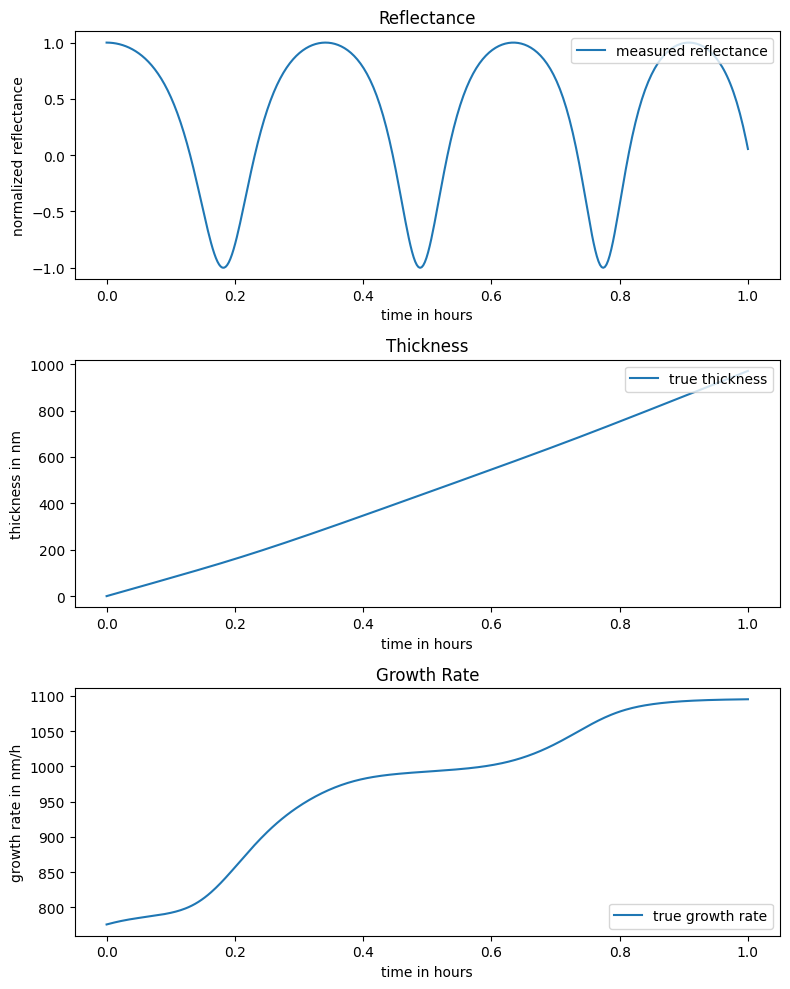

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

# plot true reflectance in the first subplot
ax1.plot(time_points, measured_reflectance, label = "measured reflectance")
ax1.set_xlabel("time in hours")
ax1.set_ylabel("normalized reflectance")
ax1.legend(loc = "upper right")
ax1.set_title("Reflectance")

# plot thickness sample in the second subplot
ax2.plot(time_points, true_thickness, label = "true thickness")
ax2.set_xlabel("time in hours")
ax2.set_ylabel("thickness in nm")
ax2.legend(loc = "upper right")
ax2.set_title("Thickness")

# plot derivative in the third subplot
ax3.plot(time_points, true_growth_rate, label = "true growth rate")
ax3.set_xlabel("time in hours")
ax3.set_ylabel("growth rate in nm/h")
ax3.legend(loc = "lower right")
ax3.set_title("Growth Rate")

plt.tight_layout()

## Inverse modeling: reflectance time series → thickness time series